In [1]:
import timm

import torch
import torchvision.transforms as transforms
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

from dino import DINOAugmentations, DINOHead, DINOLoss, MultiCropWrapper
from utils import compute_knn, gradient_clipping

/Users/lukaskuhn/Documents/Code/DINOLearn/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vit_name, dim = "vit_base_patch16_224", 768

device = "cuda" if torch.cuda.is_available() else "mps"

n_workers = 4
n_local_crops = 4
batch_size = 2
out_dim = 1024
weight_decay = 0.4
epochs = 100
momentum_teacher = 0.995

transform_aug = DINOAugmentations(local_crops_number=4, size=224)

transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(224)
])

dataset_train = CIFAR10(root='data', download=True, train=True, transform=transform_aug)
dataset_train_knn = CIFAR10(root='data', download=True, train=True, transform=transform_norm)
dataset_val_knn =  CIFAR10(root='data', download=True, train=False, transform=transform_norm)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


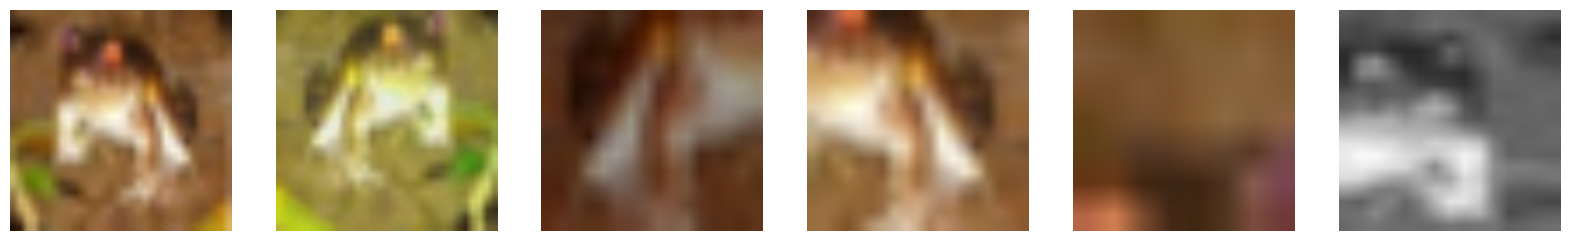

In [3]:
img = dataset_train[0][0]
# create plot with 6 images side by side
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

for i in range(len(img)):
    # denorm image
    img[i] = img[i] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    axs[i].imshow(img[i].permute(1, 2, 0))
    axs[i].axis('off')

In [4]:
data_loader_train_aug = DataLoader(dataset_train, batch_size, shuffle=True, drop_last=True, num_workers=n_workers, pin_memory=True)
data_loader_train_plain = DataLoader(dataset_train_knn, batch_size, shuffle=True, drop_last=False, num_workers=n_workers)
data_loader_val_plain = DataLoader(dataset_val_knn, batch_size, shuffle=True, drop_last=False, num_workers=n_workers)

In [5]:
student_vit = timm.create_model(vit_name)
teacher_vit = timm.create_model(vit_name)

student = MultiCropWrapper(
    student_vit,
    DINOHead(
        in_dim=dim,
        out_dim=out_dim,
        norm_last_layer=True,
    )
)

teacher = MultiCropWrapper(
    teacher_vit,
    DINOHead(
        in_dim=dim,
        out_dim=out_dim,
    )
)

teacher.load_state_dict(student.state_dict())

for p in teacher.parameters():
    p.requires_grad = False

student, teacher = student.to(device), teacher.to(device)

/Users/lukaskuhn/Documents/Code/DINOLearn/venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [6]:
loss_inst = DINOLoss(
    out_dim
).to(device)

lr = 0.0005 * batch_size / 256
optimizer = torch.optim.AdamW(
    student.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

In [7]:
def train():
    for e in range(epochs):
        student.train()
        for images, _ in tqdm(data_loader_train_aug):
            images = [img.to(device) for img in images]

            teacher_output = teacher(images[:2])
            student_output = student(images)
            
            loss = loss_inst(student_output, teacher_output)

            optimizer.zero_grad()
            loss.backward()
            gradient_clipping(student)
            optimizer.step()

            with torch.no_grad():
                for student_ps, teacher_ps in zip(student.parameters(), teacher.parameters()):
                    teacher_ps.data.mul_(momentum_teacher)
                    teacher_ps.data.add_(
                        (1-momentum_teacher) + student_ps.detach().data
                    )

        student.eval()
        current_acc = compute_knn(
            student.backbone,
            data_loader_train_plain,
            data_loader_val_plain
        )

train()

  0%|          | 12/25000 [00:17<7:02:25,  1.01s/it]